In [1]:
import sys
import os

current_dir = os.getcwd() 
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from random import sample
from datetime import datetime

from ydata_profiling import ProfileReport

# ydata have some warnings - categorical features
import warnings

warnings.filterwarnings("ignore")

# 
# os.environ["OMP_NUM_THREADS"] = "1"
from Tbx_Processing import *
from Tbx_Clustering import *
from Tbx_Exploratory import *

from Tbx_Integracao import merge_with_tolerance

# GEO (SABESP x GeoEmbraesp)

Dados agregados e agrupados
- file_path = 'data_clean/GEO_endereco.pkl'
- file_saved = 'data_clean/GEO_endereco.pkl'

obs **Sem** tolerância & **Sem** conferência IPTU.

## Importação dos dados

In [3]:
# @Carregar arquivo salvo
# Correspondencias SABESP - GeoEmbraesp
df_GEO_endereco = pd.read_pickle("../1_Integracao_Bases/data_clean/GEO_endereco.pkl").reset_index(drop = True)

# Correção tipo variável
df_GEO_endereco['Idade_predio'] = df_GEO_endereco['Idade_predio'].astype(int)

# Remoção (167) endereços com número espúrio
df_GEO_endereco = df_GEO_endereco[df_GEO_endereco['NUMERO_RUA'] != 9999999.0]

df_GEO_endereco.head()

,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,Imovel_residencial,Imovel_vertical,CEP,Idade_predio,Blocos,Unidades_andar,Andares_tipo,...,Vagas_Garagem,M2_util_unidade_tipo,M2_total_unidade_tipo,M2_Terreno,M2_util_cobertura,M2_total_cobertura,RS_total_unidade_tipo_IGPM,RS_por_M2_area_util_IGPM,RS_por_M2_area_total_IGPM,RS_total_cobertura_IGPM
0,NAO DEFINIDO,ABACATUAJA,500.0,1,0,08190-420,11,1.0,8.0,2.0,...,1.0,48.00,60.00,500.00,NaN,NaN,354125.270973,7377.602434,5902.095227,-1.000000e+00
1,PARQUE DOS DOURADOS,ABADIA DOS DOURADOS,166.0,1,1,05000-000,29,1.0,4.0,8.0,...,2.0,67.15,157.79,1127.31,113.0,223.0,767993.343318,11436.936658,4867.157813,1.222726e+06
2,GOLDEN PALACE,ABAGIBA,540.0,1,1,04294-000,29,1.0,4.0,8.0,...,1.0,58.66,106.59,1000.00,NaN,NaN,590835.653240,10073.069880,5543.200727,-1.000000e+00
3,RESERVA SAÚDE,ABAGIBA,582.0,1,1,04294-000,8,1.0,6.0,17.0,...,1.5,63.48,124.71,1467.50,NaN,NaN,789487.261442,12436.784078,6362.585522,-1.000000e+00
4,MISSOURI,ABAGIBA,583.0,1,1,04294-000,29,1.0,4.0,19.0,...,1.0,74.14,126.71,1492.91,NaN,NaN,835931.794958,11275.068377,6597.204216,-1.000000e+00


In [4]:
# @Filtragem imóveis residenciais verticais
display(df_GEO_endereco['Imovel_residencial'].value_counts())
display(df_GEO_endereco['Imovel_vertical'].value_counts())

df_GEO_residencial = df_GEO_endereco[df_GEO_endereco['Imovel_residencial'] == 1].copy()
df_GEO_res_vert = df_GEO_residencial[df_GEO_residencial['Imovel_vertical'] == 1].copy()

df_GEO_res_vert.drop(columns = ['Imovel_residencial', 'Imovel_vertical'], inplace = True)
print(df_GEO_res_vert.shape)
df_GEO_res_vert.head()

Imovel_residencial
1    7061
0     371
Name: count, dtype: int64

Imovel_vertical
1    5863
0    1569
Name: count, dtype: int64

(5492, 23)


,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,CEP,Idade_predio,Blocos,Unidades_andar,Andares_tipo,Total_Unidades,Elevadores,...,Vagas_Garagem,M2_util_unidade_tipo,M2_total_unidade_tipo,M2_Terreno,M2_util_cobertura,M2_total_cobertura,RS_total_unidade_tipo_IGPM,RS_por_M2_area_util_IGPM,RS_por_M2_area_total_IGPM,RS_total_cobertura_IGPM
1,PARQUE DOS DOURADOS,ABADIA DOS DOURADOS,166.0,05000-000,29,1.0,4.0,8.0,32.0,2.0,...,2.0,67.15,157.79,1127.31,113.0,223.0,767993.343318,11436.936658,4867.157813,1.222726e+06
2,GOLDEN PALACE,ABAGIBA,540.0,04294-000,29,1.0,4.0,8.0,32.0,2.0,...,1.0,58.66,106.59,1000.00,NaN,NaN,590835.653240,10073.069880,5543.200727,-1.000000e+00
3,RESERVA SAÚDE,ABAGIBA,582.0,04294-000,8,1.0,6.0,17.0,102.0,2.0,...,1.5,63.48,124.71,1467.50,NaN,NaN,789487.261442,12436.784078,6362.585522,-1.000000e+00
4,MISSOURI,ABAGIBA,583.0,04294-000,29,1.0,4.0,19.0,76.0,2.0,...,1.0,74.14,126.71,1492.91,NaN,NaN,835931.794958,11275.068377,6597.204216,-1.000000e+00
5,VILA PIEMONTE,ABAGIBA,603.0,04294-000,27,1.0,4.0,14.0,56.0,2.0,...,1.5,76.00,122.50,500.00,NaN,NaN,832288.142084,10951.134294,6822.238236,-1.000000e+00


In [5]:
# @Visão geral dos dados
# COluns de atenção: NUMERO_RUA, Idade_predio (?), Blocos (?), Unidades_andar (?), Total_Unidades (?), M2_util_unidade_tipo (?)
df_GEO_res_vert.describe()

,NUMERO_RUA,Idade_predio,Blocos,Unidades_andar,Andares_tipo,Total_Unidades,Elevadores,Coberturas,Dormitorios,Banheiros_Sociais,Vagas_Garagem,M2_util_unidade_tipo,M2_total_unidade_tipo,M2_Terreno,M2_util_cobertura,M2_total_cobertura,RS_total_unidade_tipo_IGPM,RS_por_M2_area_util_IGPM,RS_por_M2_area_total_IGPM,RS_total_cobertura_IGPM
count,5492.000000,5492.000000,5492.000000,5492.000000,5492.000000,5492.000000,5492.000000,5492.000000,5492.000000,5492.000000,5492.000000,5492.000000,5492.000000,5492.000000,2167.000000,2167.000000,5.492000e+03,5.492000e+03,5.492000e+03,5.492000e+03
mean,592.338674,21.729971,1.475954,4.698353,14.507067,98.646577,3.171016,1.428259,2.575710,1.889156,1.725040,96.784574,181.301345,1996.768240,179.034155,316.970279,5.799592e+11,5.659860e+09,2.988501e+09,3.628575e+11
std,854.554121,10.756409,1.402223,3.200544,5.799131,106.706114,2.576165,3.146017,0.925412,0.883288,1.084146,71.681568,135.286422,2627.530702,169.301015,297.652779,2.714029e+12,1.945180e+10,1.030709e+10,3.262948e+12
min,1.000000,2.000000,0.400000,0.500000,0.000000,4.000000,0.000000,0.000000,0.500000,1.000000,0.000000,13.760000,32.340000,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,151.000000,13.000000,1.000000,2.917500,10.000000,33.000000,2.000000,0.000000,2.000000,1.000000,1.000000,53.360000,98.392500,900.000000,0.000000,0.000000,3.819295e+05,7.927078e+03,4.484425e+03,-1.000000e+00
50%,349.000000,22.000000,1.000000,4.000000,14.000000,61.000000,2.000000,0.000000,2.500000,2.000000,1.500000,71.000000,134.420000,1310.291667,151.320000,269.070000,8.665875e+05,1.221277e+04,6.518473e+03,-1.000000e+00
75%,700.000000,30.000000,1.010000,5.922500,18.000000,120.000000,4.000000,2.000000,3.000000,2.000000,2.000000,115.657500,219.177500,2107.890000,258.648333,460.145000,2.025958e+06,1.828010e+04,9.672765e+03,9.834578e+05
max,13302.000000,39.000000,28.000000,49.500000,46.000000,1792.000000,56.000000,72.000000,5.000000,5.000000,8.000000,877.890000,1525.740000,64000.000000,1379.070000,2194.000000,5.046540e+13,2.241899e+11,1.357113e+11,1.121497e+14


In [6]:
#@Preliminar report

# profile = ProfileReport(df_GEO_endereco.iloc[:, :19, title = "Profiling Report")
# profile.to_file("preliminar_report.html")

In [7]:
# Assuming df_GEO_residencial is defined and contains the specified feature column.
plot_map = {
    'title_text1': 'Instances / {feature}',
    'title_text2': 'Distribution - {feature}',
    'x_label_text': 'Quantidade de unidades',
    'y_label_text': 'Proportion',
    'title_fontsize': 16,
    'label_fontsize': 14,
    'tick_fontsize': 12,
    'legend_fontsize': 12,

    'y_label_text0': 'Count instances',
    }

# _ = create_threshold_analysis(data = df_GEO_residencial, feature = 'Total_Unidades', plot_map = plot_map,
#                               tags = (False, True), filter_data = True,
#                               plot_analsis = True, threshold = 15, xlim = (0, 500))

## Exemplo de filtragens

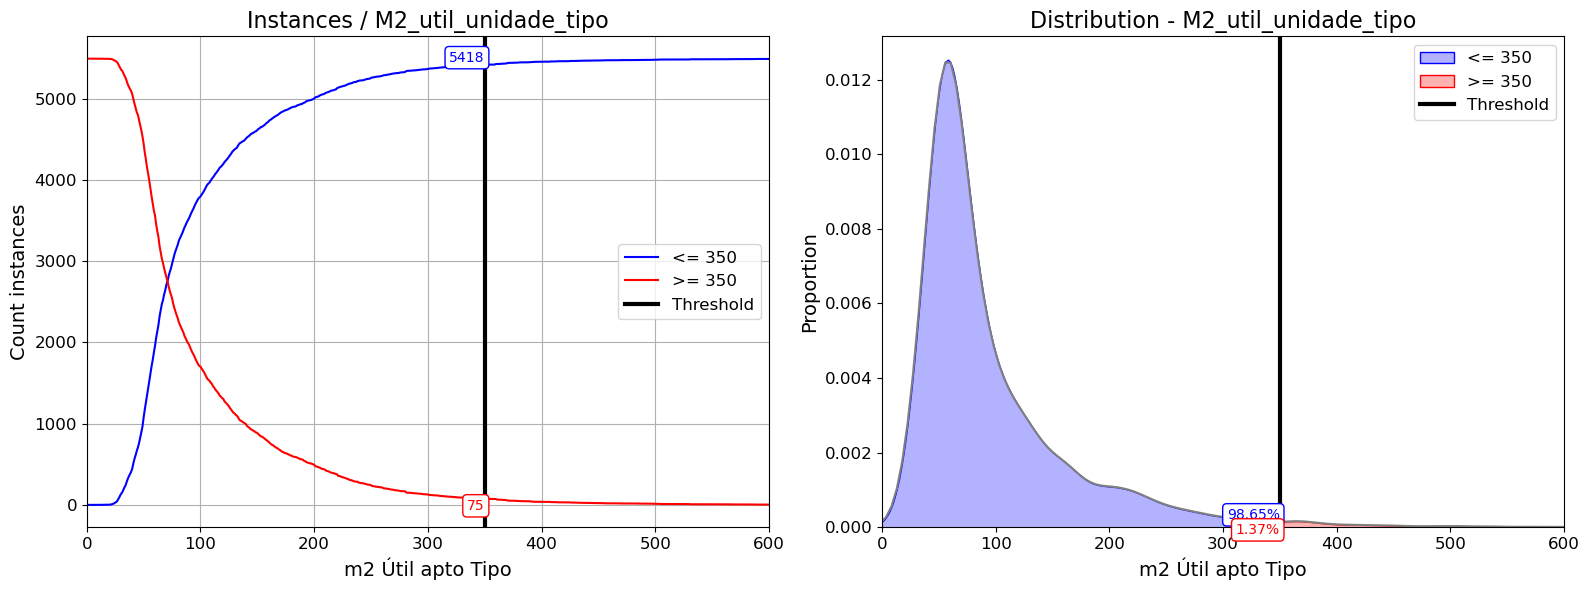

In [8]:
plot_map['x_label_text'] = 'm2 Útil apto Tipo'
_ = create_threshold_analysis(data = df_GEO_res_vert, feature = 'M2_util_unidade_tipo', plot_map = plot_map,
                              tags = (True, False), filter_data = False,
                              plot_analsis = True, threshold = 350, xlim = (0, 600))

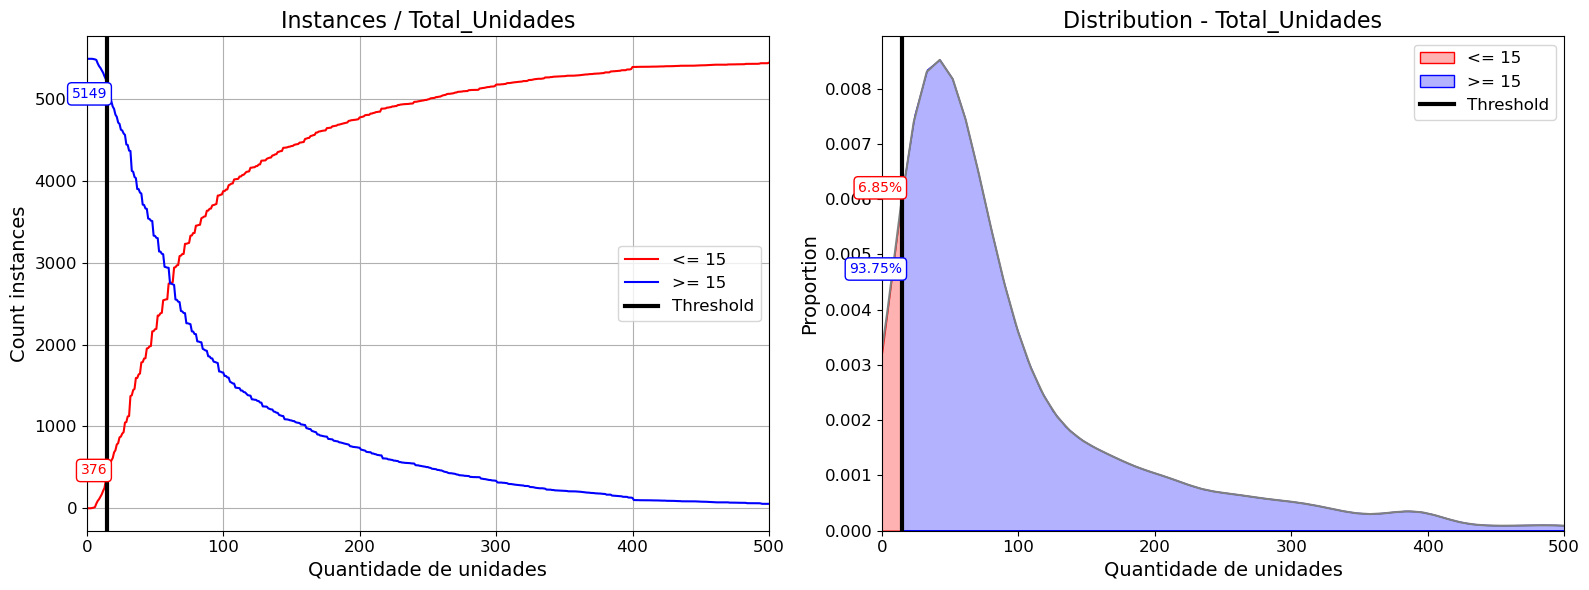

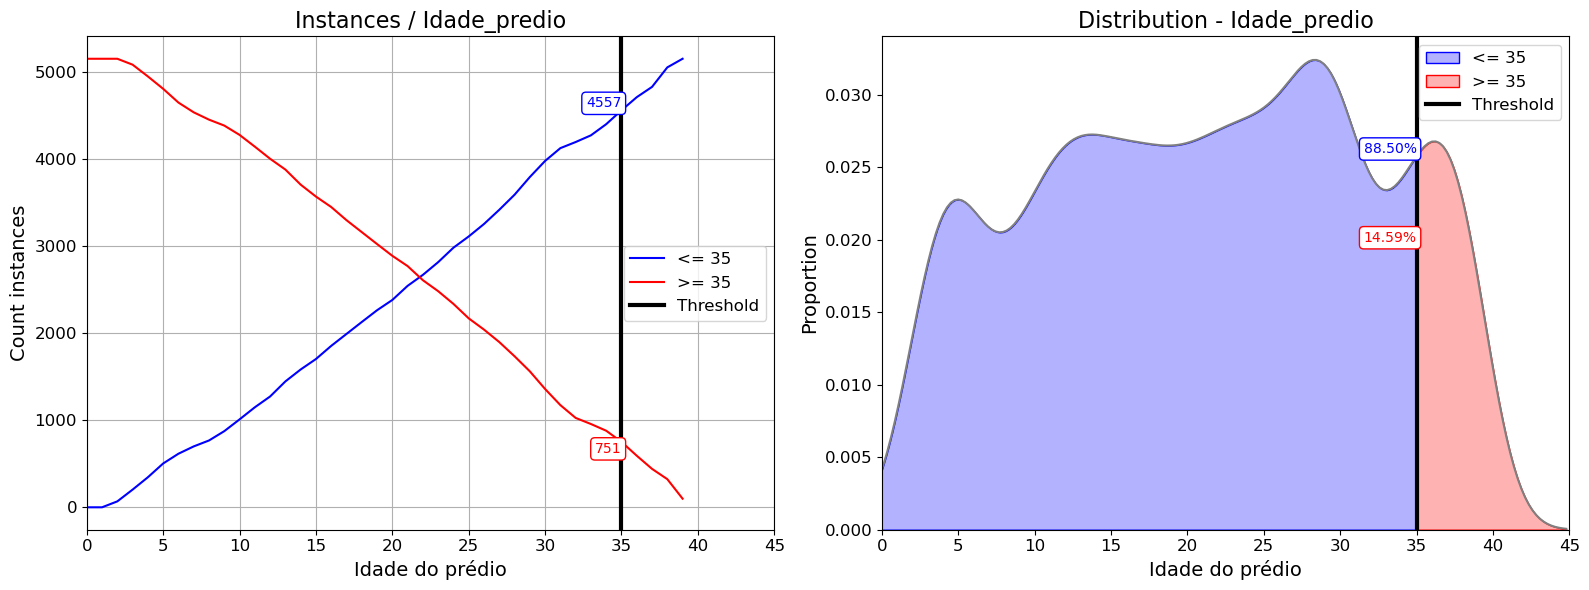

In [9]:
plot_map['x_label_text'] = 'Quantidade de unidades'
df_GEO_res_unid = create_threshold_analysis(data = df_GEO_res_vert, feature = 'Total_Unidades', plot_map = plot_map,
                                            tags = (False, True), filter_data = True,
                                            plot_analsis = True, threshold = 15, xlim = (0, 500))

plot_map['x_label_text'] = 'Idade do prédio'
df_GEO_res_unid_idade = create_threshold_analysis(data = df_GEO_res_unid, feature = 'Idade_predio', plot_map = plot_map,
                                                  tags = (True, False), filter_data = True,
                                                  plot_analsis = True, threshold = 35, xlim = (0, 45))

***
***
***


## Preprocessamento
### Valores faltantes

In [11]:
# Voltando a codificação de valores nulos
for c in df_GEO_res_vert.columns:
    if df_GEO_res_vert[c].min() == -1:
        df_GEO_res_vert[c] = df_GEO_res_vert[c].replace(-1, np.nan)

# Casos sem cobertura -> imputado valor 0
preco_cob_nan = df_GEO_res_vert[df_GEO_res_vert['M2_util_cobertura'].isna()]

df_GEO_res_vert.loc[preco_cob_nan.index, 'M2_util_cobertura'] = 0
df_GEO_res_vert.loc[preco_cob_nan.index, 'M2_total_cobertura'] = 0
df_GEO_res_vert.loc[preco_cob_nan.index, 'RS_total_cobertura_GEOPM'] = 0

print('Valores faltantes:')
df_GEO_res_vert.isna().sum()[df_GEO_res_vert.isna().sum() > 0].sort_values(ascending = False)

Valores faltantes:


RS_total_cobertura_IGPM       3787
RS_total_cobertura_GEOPM      2167
RS_total_unidade_tipo_IGPM     771
RS_por_M2_area_util_IGPM       771
RS_por_M2_area_total_IGPM      771
dtype: int64

In [12]:
preco_tipo_nan = df_GEO_res_vert[df_GEO_res_vert['RS_por_M2_area_util_IGPM'].isna()]
preco_tipo_nan.head()

,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,CEP,Idade_predio,Blocos,Unidades_andar,Andares_tipo,Total_Unidades,Elevadores,...,M2_total_unidade_tipo,M2_Terreno,M2_util_cobertura,M2_total_cobertura,RS_total_unidade_tipo_IGPM,RS_por_M2_area_util_IGPM,RS_por_M2_area_total_IGPM,RS_total_cobertura_IGPM,M2_util_unidade_tipo_filter,RS_total_cobertura_GEOPM
45,FREE SERVICE FLAT,ADOLFO PINHEIRO,1145.0,04733-100,37,1.0,9.0,8.0,72.0,3.0,...,80.00,1500.00,0.0,0.0,NaN,NaN,NaN,NaN,True,0.0
46,FREE SERVICE FLAT,ADOLFO PINHEIRO,1145.0,04734-002,37,1.0,9.0,8.0,72.0,3.0,...,80.00,1500.00,0.0,0.0,NaN,NaN,NaN,NaN,True,0.0
50,TOWERS CHAMPION CIDADE JARDIM,ADOLFO TABACOW,221.0,01453-040,38,2.0,1.0,7.0,14.0,4.0,...,500.00,2005.00,0.0,0.0,NaN,NaN,NaN,NaN,True,NaN
53,PALAZZO VERONEZI E PALAZZO DI MORANO,AFONSO BRAZ,527.0,04511-001,37,2.0,2.0,18.0,72.0,4.0,...,225.00,2510.00,0.0,0.0,NaN,NaN,NaN,NaN,True,NaN
56,AMBASSADOR FLAT SERVICE,AFONSO BRAZ,768.0,04511-001,38,1.0,4.0,17.0,68.0,2.0,...,95.36,1014.74,0.0,0.0,NaN,NaN,NaN,NaN,True,0.0


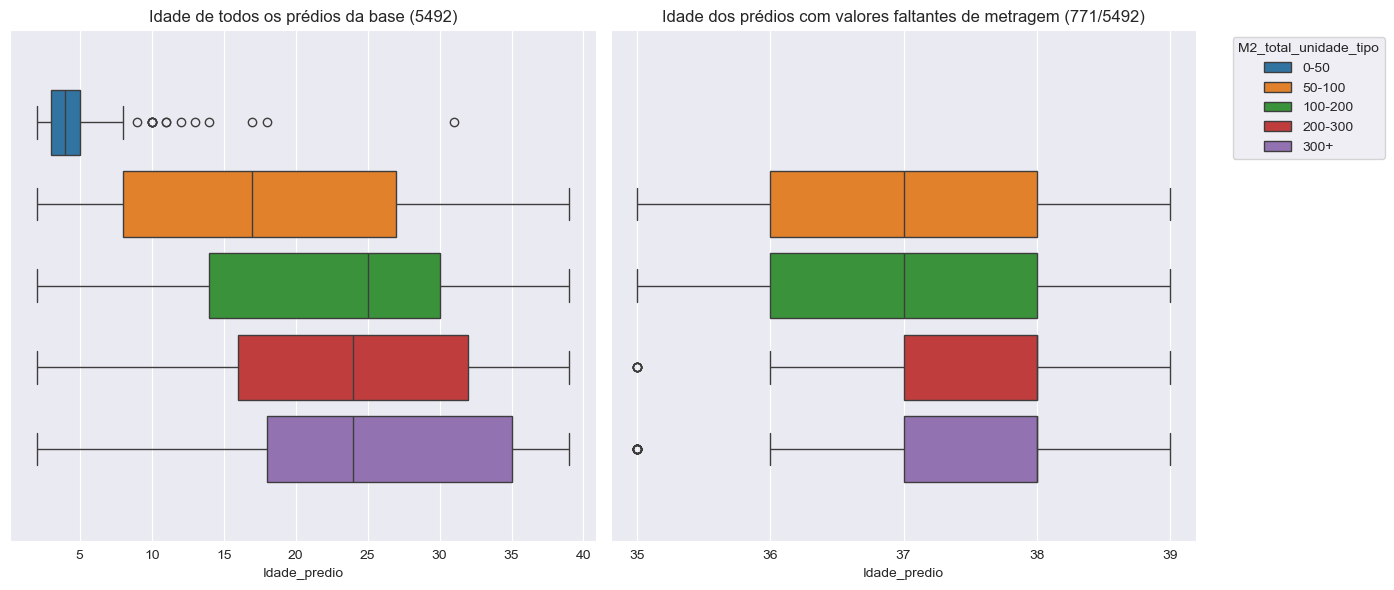

In [13]:
boxplots_idade(df_GEO_res_vert, preco_tipo_nan, bins = None)

***
***

### Quanto à idade dos prédios

In [14]:
# @Carregar arquivo salvo
# Base tratada da GeoEmbraesp - complementação info
data_GEO_SP = pd.read_pickle("../1_Integracao_Bases/data_clean/data_GEO_SP.pkl").reset_index(drop = True)
data_GEO_SP['Idade_predio'] = data_GEO_SP['Idade_predio'].astype(int)

# Somente imoveis residenciais verticais
data_GEO_SP = data_GEO_SP[data_GEO_SP['Imovel_residencial'] == 1]
data_GEO_SP = data_GEO_SP[data_GEO_SP['Imovel_vertical'] == 1]

GEO_lancamento = data_GEO_SP[
    ['Empreendimento_Nome', 'DESC_RUA', 'NUMERO_RUA', 'data_lancamento']].drop_duplicates()

GEO_lancamento = pd.merge(df_GEO_res_vert, GEO_lancamento, how = 'left',
                          on = GEO_lancamento.columns.tolist().remove('data_lancamento'))

GEO_lancamento.head()

,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,CEP,Idade_predio,Blocos,Unidades_andar,Andares_tipo,Total_Unidades,Elevadores,...,M2_Terreno,M2_util_cobertura,M2_total_cobertura,RS_total_unidade_tipo_IGPM,RS_por_M2_area_util_IGPM,RS_por_M2_area_total_IGPM,RS_total_cobertura_IGPM,M2_util_unidade_tipo_filter,RS_total_cobertura_GEOPM,data_lancamento
0,PARQUE DOS DOURADOS,ABADIA DOS DOURADOS,166.0,05000-000,29,1.0,4.0,8.0,32.0,2.0,...,1127.31,113.0,223.0,767993.343318,11436.936658,4867.157813,1.222726e+06,True,NaN,1995-05-01
1,GOLDEN PALACE,ABAGIBA,540.0,04294-000,29,1.0,4.0,8.0,32.0,2.0,...,1000.00,0.0,0.0,590835.653240,10073.069880,5543.200727,NaN,True,0.0,1995-07-01
2,RESERVA SAÚDE,ABAGIBA,582.0,04294-000,8,1.0,6.0,17.0,102.0,2.0,...,1467.50,0.0,0.0,789487.261442,12436.784078,6362.585522,NaN,True,0.0,2016-04-01
3,MISSOURI,ABAGIBA,583.0,04294-000,29,1.0,4.0,19.0,76.0,2.0,...,1492.91,0.0,0.0,835931.794958,11275.068377,6597.204216,NaN,True,0.0,1995-04-01
4,VILA PIEMONTE,ABAGIBA,603.0,04294-000,27,1.0,4.0,14.0,56.0,2.0,...,500.00,0.0,0.0,832288.142084,10951.134294,6822.238236,NaN,True,0.0,1997-09-01


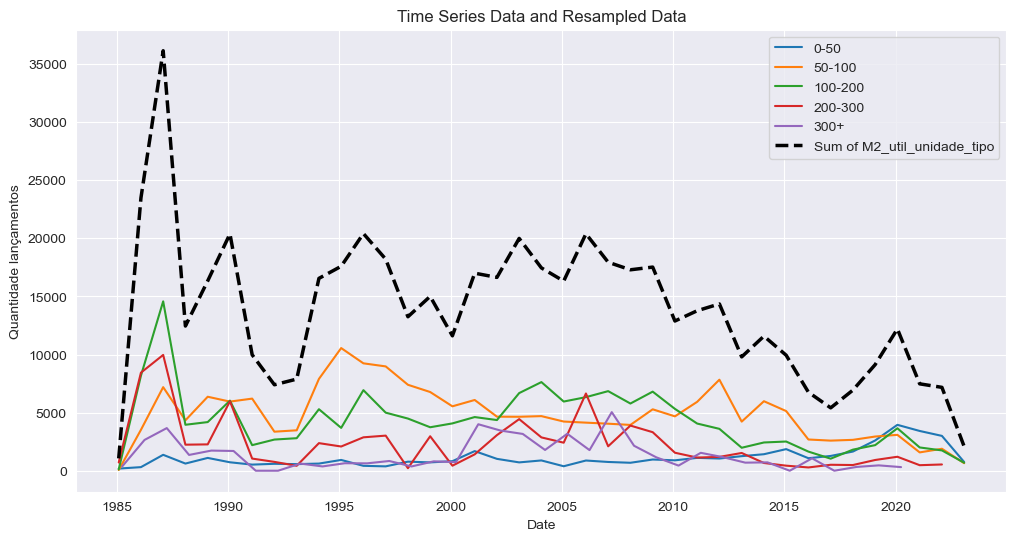

In [15]:
tgt_val = 'M2_util_unidade_tipo'
granularity = '12M'
plot_time_series_with_resampling(data = GEO_lancamento,
                                 tgt_val = tgt_val,
                                 granularity = granularity,
                                 agg_func = 'sum',
                                 # date_range = ('2013', '2023'),
                                 )

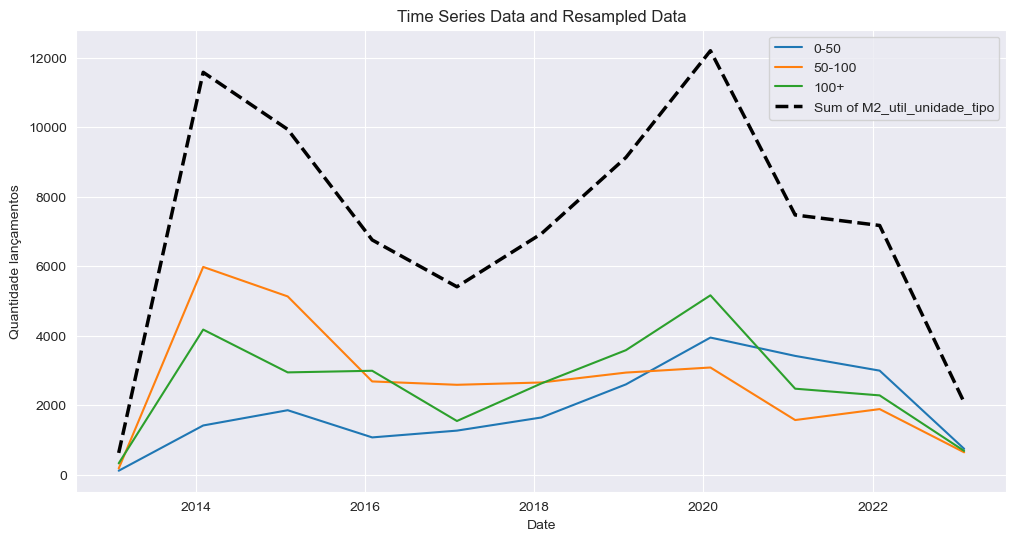

In [16]:
plot_time_series_with_resampling(data = GEO_lancamento,
                                 tgt_val = tgt_val,
                                 granularity = '12M',
                                 agg_func = 'sum',
                                 date_range = ('2013', '2023'),
                                 bins = [0, 50, 100, np.inf]
                                 )

Acumulado da soma de m2 para cada faixa de tamanho de apto aponta tendência de apartamentos menores (0-50m2)

Proporção prédios novos (>2000) / Total:	3092 / 5492


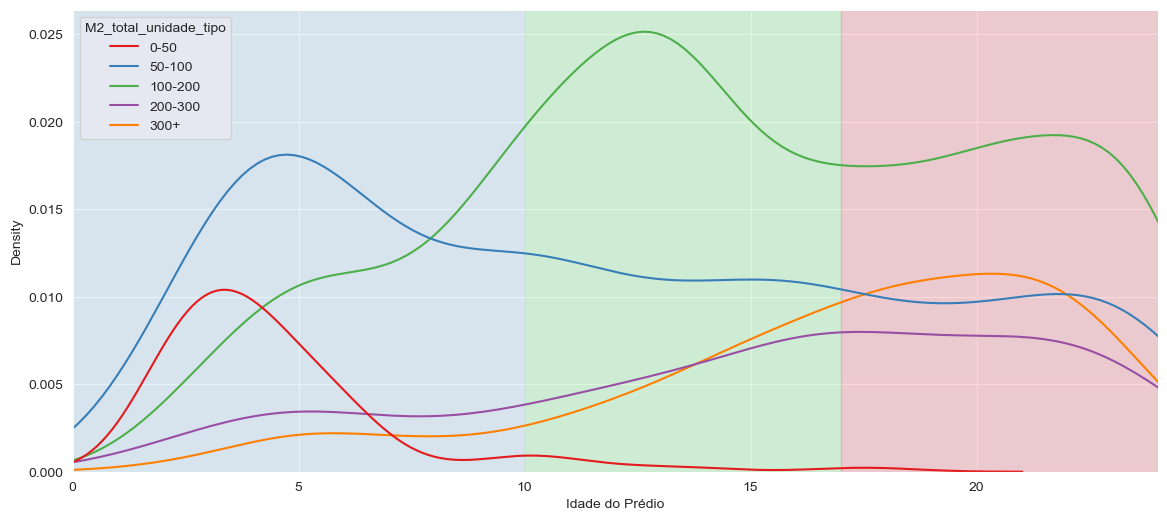

In [17]:
plot_building_age_density(df_GEO_res_vert)

## Consumo - número de PDEs

In [18]:
# @Carregar arquivo salvo
data_SP_checked = pd.read_pickle("../1_Integracao_Bases/data_clean/data_SP.pkl")

data_SP_clean = data_SP_checked[['CEP', 'DESC_RUA', 'NUMERO_RUA', 'PDE']].drop_duplicates()

pdes_agg = data_SP_clean.groupby(data_SP_clean.columns[:3].tolist()).count().reset_index().rename(
    columns = {'PDE': 'PDE_Count'})

# data_SP_clean = pd.merge(data_SP_clean, pdes_agg, on = ['CEP', 'DESC_RUA', 'NUMERO_RUA'], how = 'left')

data_SP_clean.head()

,CEP,DESC_RUA,NUMERO_RUA,PDE
0,03385-100,LUIS MARIN DOS SANTOS,87.0,2000478360
1,03385-060,LAZARO GONCALVES FRAGA,58.0,0746231849
2,03385-050,SERAFIM DE ABREU,8.0,0929391632
3,03385-090,ACAPORI,12.0,0125062575
4,03729-100,FALANTO,68.0,0604648529


In [19]:
merge1 = pd.merge(df_GEO_res_vert, data_SP_clean, on = ['CEP', 'DESC_RUA', 'NUMERO_RUA'], how = 'left')
# print('PDEs unicos: ', len(merge1['PDE'].unique()))
mrg1 = merge1[~merge1['PDE'].isna()].drop_duplicates()

merge2 = merge1[merge1['PDE'].isna()].drop_duplicates().copy()
merge2 = pd.merge(merge2.drop(columns = 'PDE'), data_SP_clean.drop(columns = 'DESC_RUA'), on = ['CEP', 'NUMERO_RUA'],
                  how = 'left')
# print('PDEs unicos: ', len(merge2['PDE'].unique()))
mrg2 = merge2[~merge2['PDE'].isna()].drop_duplicates()

merge3 = merge2[merge2['PDE'].isna()].drop_duplicates().copy()
merge3 = pd.merge(merge3.drop(columns = 'PDE'), data_SP_clean.drop(columns = 'CEP'), on = ['DESC_RUA', 'NUMERO_RUA'],
                  how = 'left')
# print('PDEs unicos: ', len(merge3['PDE'].unique()))
mrg3 = merge3[~merge3['PDE'].isna()].drop_duplicates()

df_pde = pd.concat([mrg1, mrg2, mrg3], axis = 0).drop_duplicates()

df_pde = pd.merge(df_pde, pdes_agg, on = ['CEP', 'DESC_RUA', 'NUMERO_RUA'], how = 'left')

# df_pde.to_pickle("data_clean/df_pde.pkl")

df_pde.head()

,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,CEP,Idade_predio,Blocos,Unidades_andar,Andares_tipo,Total_Unidades,Elevadores,...,M2_util_cobertura,M2_total_cobertura,RS_total_unidade_tipo_IGPM,RS_por_M2_area_util_IGPM,RS_por_M2_area_total_IGPM,RS_total_cobertura_IGPM,M2_util_unidade_tipo_filter,RS_total_cobertura_GEOPM,PDE,PDE_Count
0,PARQUE DOS DOURADOS,ABADIA DOS DOURADOS,166.0,05000-000,29,1.0,4.0,8.0,32.0,2.0,...,113.0,223.0,767993.343318,11436.936658,4867.157813,1.222726e+06,True,NaN,0568137914,2.0
1,PARQUE DOS DOURADOS,ABADIA DOS DOURADOS,166.0,05000-000,29,1.0,4.0,8.0,32.0,2.0,...,113.0,223.0,767993.343318,11436.936658,4867.157813,1.222726e+06,True,NaN,0245762124,2.0
2,GOLDEN PALACE,ABAGIBA,540.0,04294-000,29,1.0,4.0,8.0,32.0,2.0,...,0.0,0.0,590835.653240,10073.069880,5543.200727,NaN,True,0.0,0409469165,1.0
3,RESERVA SAÚDE,ABAGIBA,582.0,04294-000,8,1.0,6.0,17.0,102.0,2.0,...,0.0,0.0,789487.261442,12436.784078,6362.585522,NaN,True,0.0,0072401044,1.0
4,MISSOURI,ABAGIBA,583.0,04294-000,29,1.0,4.0,19.0,76.0,2.0,...,0.0,0.0,835931.794958,11275.068377,6597.204216,NaN,True,0.0,0072428759,1.0


In [20]:
size_pde = df_pde[['DESC_RUA', 'NUMERO_RUA', 'CEP', 'Total_Unidades', 'PDE_Count']].drop_duplicates()

int(size_pde['Total_Unidades'].sum()), int(size_pde['PDE_Count'].sum())

(473089, 16655)

### Trabalhando com tolerância

In [21]:
# tgts_GEO = merge3[merge3['PDE'].isna()].drop_duplicates()
# df2 = pd.merge(tgts_GEO.iloc[:, :4], data_GEO_SP.iloc[:, :4], on = ['Empreendimento_Nome', 'DESC_RUA'], how = 'left',
#                suffixes = ('_geo', '_sab')).dropna().drop_duplicates()
# df2 = df2[df2['NUMERO_RUA_geo'] != df2['NUMERO_RUA_sab']]
# 
# df2

In [22]:
tol_NUMERO = 40

df_GEO_clean = df_GEO_res_vert[['Empreendimento_Nome', 'DESC_RUA', 'NUMERO_RUA', 'CEP', 'Total_Unidades']].reset_index()

DATA_PDE = merge_with_tolerance(df1 = df_GEO_clean,
                                 df2 = pdes_agg,
                                 id_dfs = ['_geo', '_sab'],
                                 agg_cols = ['CEP'],
                                 var_col = 'NUMERO_RUA',
                                 tolerance = tol_NUMERO)

# Remove casos de lados opostos da rua
DATA_PDE = DATA_PDE[(DATA_PDE['NUMERO_RUA_geo'] - DATA_PDE['NUMERO_RUA_sab']) % 2 == 0]

DATA_PDE['checked_endereco'] = np.where(
    (DATA_PDE['NUMERO_RUA_sab'] == DATA_PDE['NUMERO_RUA_geo']) & (DATA_PDE['DESC_RUA_geo'] == DATA_PDE['DESC_RUA_sab']),
    True,
    False
    )

mask = DATA_PDE.groupby('index')['checked_endereco'].transform('any') & DATA_PDE['checked_endereco']
checked_cases = DATA_PDE[mask]

DATA_PDE_tgts = DATA_PDE[~DATA_PDE['index'].isin(checked_cases['index'])].drop(columns = 'checked_endereco')

DATA_PDE_tgts['checked_rua'] = np.where(DATA_PDE_tgts['DESC_RUA_geo'] == DATA_PDE_tgts['DESC_RUA_sab'],
                                             True,
                                             False
                                             )

DATA_PDE_tgts['ratio_counts'] = DATA_PDE_tgts['PDE_Count'] / DATA_PDE_tgts['Total_Unidades']

DATA_PDE_tgts[(abs(1 - DATA_PDE_tgts['ratio_counts']) < 0.1) & (DATA_PDE_tgts['checked_rua'])][DATA_PDE_tgts.columns.sort_values()]

,CEP,DESC_RUA_geo,DESC_RUA_sab,Empreendimento_Nome,NUMERO_RUA_geo,NUMERO_RUA_sab,PDE_Count,Total_Unidades,checked_rua,index,ratio_counts
3259926,05414-001,CONEGO EUGENIO LEITE,CONEGO EUGENIO LEITE,TANGARÁ PINHEIROS,854.0,866.0,55,52.0,True,1734,1.057692
3755306,03061-000,TOLEDO BARBOSA,TOLEDO BARBOSA,SAINT JOSEPH,631.0,637.0,69,68.0,True,7130,1.014706


**Conclusões:**
- Difícil trabalhar com tolerãncia de numero de PDEs cadastrados x Total Unidades -> prédios mais antigos não tem consumo individualizado


***
***
***

## Questionamentos:

1 - Quais filtros mais interessantes para aplicar? (Idade, tamanho tipo, quantidade de consumidores)

2 - Trabalhar com tolerancia exige dados dos consumos de endereços adjacentes -> normalizado para consumo por unidade?


***
***
***

# GEO_IPTU (SABESP x GeoEmbraesp x IPTU)


In [23]:
# @Carregar arquivo salvo
# Correspondencias SABESP - GeoEmbraesp
df_iptu_geo = pd.read_pickle("../1_Integracao_Bases/data_clean/iptu_geo_sabesp_rlx.pkl")

# Correção tipo variável
df_iptu_geo['Idade_predio'] = df_iptu_geo['Idade_predio'].astype(int)

df_iptu_geo.head()

,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,Imovel_residencial,Imovel_vertical,CEP,Idade_predio,Blocos,Unidades_andar,Andares_tipo,...,QUANTIDADE DE PAVIMENTOS,TESTADA PARA CALCULO,FATOR DE OBSOLESCENCIA,CONTAGEM_UNIDADES,VALOR DO M2 DO TERRENO,AREA DO TERRENO,VALOR DO M2 DE CONSTRUCAO,AREA CONSTRUIDA,Padrao,Fator_obsolescencia_calculado
0,NAO DEFINIDO,ABACATUAJA,500.0,1,0,08190-420,11,1.0,8.0,2.0,...,2.0,10.0,0.86,8.0,446.0,500.0,1420.0,466.0,B,0.86
2,GOLDEN PALACE,ABAGIBA,540.0,1,1,04294-000,29,1.0,4.0,8.0,...,9.0,40.0,0.74,32.0,1557.0,1000.0,2291.0,3424.0,C,0.71
3,RESERVA SAÚDE,ABAGIBA,582.0,1,1,04294-000,8,1.0,6.0,17.0,...,18.0,120.0,0.96,102.0,1557.0,2935.0,2291.0,10603.0,C,0.94
4,MISSOURI,ABAGIBA,583.0,1,1,04294-000,29,1.0,4.0,19.0,...,20.0,30.0,0.74,76.0,1602.0,1500.0,2291.0,10703.0,C,0.71
5,VILA PIEMONTE,ABAGIBA,603.0,1,1,04294-000,27,1.0,4.0,14.0,...,15.0,20.0,0.80,56.0,1602.0,1000.0,2291.0,6778.0,C,0.74


In [24]:
# @Filtragem imóveis residenciais verticais
display(df_iptu_geo['Imovel_residencial'].value_counts())
display(df_iptu_geo['Imovel_vertical'].value_counts())

df_IG_residencial = df_iptu_geo[df_iptu_geo['Imovel_residencial'] == 1].copy()
df_IG_res_vert = df_IG_residencial[df_IG_residencial['Imovel_vertical'] == 1].copy()

df_IG_res_vert.drop(columns = ['Imovel_residencial', 'Imovel_vertical'], inplace = True)
print(df_IG_res_vert.shape)
df_IG_res_vert.head()

Imovel_residencial
1    4638
0     291
Name: count, dtype: int64

Imovel_vertical
1    3802
0    1127
Name: count, dtype: int64

(3516, 33)


,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,CEP,Idade_predio,Blocos,Unidades_andar,Andares_tipo,Total_Unidades,Elevadores,...,QUANTIDADE DE PAVIMENTOS,TESTADA PARA CALCULO,FATOR DE OBSOLESCENCIA,CONTAGEM_UNIDADES,VALOR DO M2 DO TERRENO,AREA DO TERRENO,VALOR DO M2 DE CONSTRUCAO,AREA CONSTRUIDA,Padrao,Fator_obsolescencia_calculado
2,GOLDEN PALACE,ABAGIBA,540.0,04294-000,29,1.0,4.0,8.0,32.0,2.0,...,9.0,40.0,0.74,32.0,1557.0,1000.0,2291.0,3424.0,C,0.71
3,RESERVA SAÚDE,ABAGIBA,582.0,04294-000,8,1.0,6.0,17.0,102.0,2.0,...,18.0,120.0,0.96,102.0,1557.0,2935.0,2291.0,10603.0,C,0.94
4,MISSOURI,ABAGIBA,583.0,04294-000,29,1.0,4.0,19.0,76.0,2.0,...,20.0,30.0,0.74,76.0,1602.0,1500.0,2291.0,10703.0,C,0.71
5,VILA PIEMONTE,ABAGIBA,603.0,04294-000,27,1.0,4.0,14.0,56.0,2.0,...,15.0,20.0,0.80,56.0,1602.0,1000.0,2291.0,6778.0,C,0.74
6,VALE DO SOL,ABAGIBA,1200.0,04294-000,17,2.0,4.0,10.5,84.0,6.0,...,12.0,0.0,0.88,115.0,1606.0,2312.0,2291.0,14636.0,C,0.85


In [25]:
# Voltando a codificação de valores nulos
for c in df_IG_res_vert.columns:
    if df_IG_res_vert[c].min() == -1:
        df_IG_res_vert[c] = df_IG_res_vert[c].replace(-1, np.nan)

# Casos sem cobertura -> imputado valor 0

preco_cob_nan = df_IG_res_vert[df_IG_res_vert['M2_util_cobertura'].isna()]

df_IG_res_vert.loc[preco_cob_nan.index, 'M2_util_cobertura'] = 0
df_IG_res_vert.loc[preco_cob_nan.index, 'M2_total_cobertura'] = 0
df_IG_res_vert.loc[preco_cob_nan.index, 'RS_total_cobertura_IGPM'] = 0

print('Valores faltantes:')
df_IG_res_vert.isna().sum()[df_IG_res_vert.isna().sum() > 0].sort_values(ascending = False)

Valores faltantes:


RS_total_unidade_tipo_IGPM    481
RS_por_M2_area_util_IGPM      481
RS_por_M2_area_total_IGPM     481
RS_total_cobertura_IGPM       339
dtype: int64

In [26]:
merge1 = pd.merge(df_IG_res_vert, data_SP_clean, on = ['CEP', 'DESC_RUA', 'NUMERO_RUA'], how = 'left')
# print('PDEs unicos: ', len(merge1['PDE'].unique()))
mrg1 = merge1[~merge1['PDE'].isna()].drop_duplicates()

merge2 = merge1[merge1['PDE'].isna()].drop_duplicates().copy()
merge2 = pd.merge(merge2.drop(columns = 'PDE'), data_SP_clean.drop(columns = 'DESC_RUA'), on = ['CEP', 'NUMERO_RUA'],
                  how = 'left')
# print('PDEs unicos: ', len(merge2['PDE'].unique()))
mrg2 = merge2[~merge2['PDE'].isna()].drop_duplicates()

merge3 = merge2[merge2['PDE'].isna()].drop_duplicates().copy()
merge3 = pd.merge(merge3.drop(columns = 'PDE'), data_SP_clean.drop(columns = 'CEP'), on = ['DESC_RUA', 'NUMERO_RUA'],
                  how = 'left')
# print('PDEs unicos: ', len(merge3['PDE'].unique()))
mrg3 = merge3[~merge3['PDE'].isna()].drop_duplicates()

df_pde_iptu = pd.concat([mrg1, mrg2, mrg3], axis = 0).drop_duplicates()

df_pde_iptu = pd.merge(df_pde_iptu, pdes_agg, on = ['CEP', 'DESC_RUA', 'NUMERO_RUA'], how = 'left')

# df_pde_iptu.to_pickle("data_clean/df_pde_iptu.pkl")

df_pde_iptu.head()

,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,CEP,Idade_predio,Blocos,Unidades_andar,Andares_tipo,Total_Unidades,Elevadores,...,FATOR DE OBSOLESCENCIA,CONTAGEM_UNIDADES,VALOR DO M2 DO TERRENO,AREA DO TERRENO,VALOR DO M2 DE CONSTRUCAO,AREA CONSTRUIDA,Padrao,Fator_obsolescencia_calculado,PDE,PDE_Count
0,GOLDEN PALACE,ABAGIBA,540.0,04294-000,29,1.0,4.0,8.0,32.0,2.0,...,0.74,32.0,1557.0,1000.0,2291.0,3424.0,C,0.71,0409469165,1.0
1,RESERVA SAÚDE,ABAGIBA,582.0,04294-000,8,1.0,6.0,17.0,102.0,2.0,...,0.96,102.0,1557.0,2935.0,2291.0,10603.0,C,0.94,0072401044,1.0
2,MISSOURI,ABAGIBA,583.0,04294-000,29,1.0,4.0,19.0,76.0,2.0,...,0.74,76.0,1602.0,1500.0,2291.0,10703.0,C,0.71,0072428759,1.0
3,VILA PIEMONTE,ABAGIBA,603.0,04294-000,27,1.0,4.0,14.0,56.0,2.0,...,0.80,56.0,1602.0,1000.0,2291.0,6778.0,C,0.74,0072428678,1.0
4,VALE DO SOL,ABAGIBA,1200.0,04294-000,17,2.0,4.0,10.5,84.0,6.0,...,0.88,115.0,1606.0,2312.0,2291.0,14636.0,C,0.85,0705845320,1.0


In [27]:
size_pde_iptu = df_pde_iptu[['DESC_RUA', 'NUMERO_RUA', 'CEP', 'Total_Unidades', 'PDE_Count']].drop_duplicates()

int(size_pde_iptu['Total_Unidades'].sum()), int(size_pde_iptu['PDE_Count'].sum())

(263168, 12140)

In [28]:
int(size_pde['Total_Unidades'].sum()), int(size_pde['PDE_Count'].sum())

(473089, 16655)

In [1]:
import pandas as pd

In [9]:
df_pde = pd.read_pickle("data_clean/df_pde.pkl")

cols = ['PDE', 'DESC_RUA', 'NUMERO_RUA', 'CEP']

df_pde = df_pde[cols].drop_duplicates()

df_pde

,PDE,DESC_RUA,NUMERO_RUA,CEP
0,0568137914,ABADIA DOS DOURADOS,166.0,05000-000
1,0245762124,ABADIA DOS DOURADOS,166.0,05000-000
2,0409469165,ABAGIBA,540.0,04294-000
3,0072401044,ABAGIBA,582.0,04294-000
4,0072428759,ABAGIBA,583.0,04294-000
...,...,...,...,...
18856,0070799741,VINTE E OITO DE SETEMBRO,1121.0,01000-000
18857,0520958942,VISCONDE DE INHAUMA,81.0,04143-010
18858,0572199821,WINIFRED,200.0,03431-000
18859,0169617149,XIRO,168.0,02517-160


In [10]:
df_pde_iptu = pd.read_pickle("data_clean/df_pde_iptu.pkl")

df_pde_iptu = df_pde_iptu[cols].drop_duplicates()

df_pde_iptu

,PDE,DESC_RUA,NUMERO_RUA,CEP
0,0409469165,ABAGIBA,540.0,04294-000
1,0072401044,ABAGIBA,582.0,04294-000
2,0072428759,ABAGIBA,583.0,04294-000
3,0072428678,ABAGIBA,603.0,04294-000
4,0705845320,ABAGIBA,1200.0,04294-000
...,...,...,...,...
12996,0161393640,PADRE BENEDITO DE CAMARGO,170.0,03604-000
12997,0088474798,PASTOR RUBENS LOPES,226.0,04409-020
12998,0126848483,RENATO RINALDI,650.0,03426-000
12999,0763731005,SERGIO TOMAS,422.0,01131-010


In [12]:
qwe = pd.concat([df_pde, df_pde_iptu], axis = 0).drop_duplicates()
qwe.to_csv('data_clean/PDE_0111.csv', index = False)

In [14]:
asd = pd.read_csv('data_clean/PDE_0111.csv')
asd

,PDE,DESC_RUA,NUMERO_RUA,CEP
0,568137914,ABADIA DOS DOURADOS,166.0,05000-000
1,245762124,ABADIA DOS DOURADOS,166.0,05000-000
2,409469165,ABAGIBA,540.0,04294-000
3,72401044,ABAGIBA,582.0,04294-000
4,72428759,ABAGIBA,583.0,04294-000
...,...,...,...,...
18596,100002161,RUBIACEA,137.0,02335-020
18597,885353633,VILA EMA,2142.0,03282-000
18598,208852611,VILA EMA,2142.0,03282-000
18599,885355768,VILA EMA,2142.0,03282-000
